In [1]:
#importing standard library
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_datasets as tfds
dataSet = tfds.load('amazon_us_reviews/Mobile_Electronics_v1_00', split='train', shuffle_files=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/104975 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0.incompleteLZALCG/amazon_us_re…

Dataset amazon_us_reviews downloaded and prepared to ~/tensorflow_datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0. Subsequent calls will reuse this data.


# Preprocessing via Pandas dataframe

In [2]:
# Converting Prefect tensorflow dataset  into pandas dataframe
DataFrame = tfds.as_dataframe(dataSet)


In [3]:
DataFrame["Sentiment"] = DataFrame["data/star_rating"]
DataFrame['short_review'] =DataFrame['data/review_body']
DataFrame_me = DataFrame[["short_review", "Sentiment"]]
DataFrame_me

,short_review,Sentiment
0,b'Does not work',1
1,b'This is a great wiring kit i used it to set ...,4
2,b'It works great so much faster than USB charg...,5
3,b'This product was purchased to hold a monitor...,5
4,"b""it works but it has really bad sound quality...",3
...,...,...
104970,"b""It's a wonderful invention. You don't need t...",4
104971,"b""This is not good item,I can even maket work,...",1
104972,b'The cover and skin were both exactly like th...,5
104973,b'I ordered 2 of these cords for both mine and...,1


Text(0.5, 0, 'Sentiment rating category')

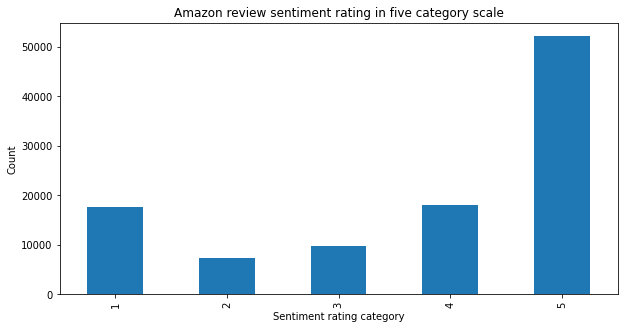

In [4]:
from matplotlib import pyplot as plt
DataFrame["data/star_rating"].value_counts().sort_index().plot(kind='bar', title="Amazon review sentiment rating", figsize=(10,5))

plt.title("Amazon review sentiment rating in five category scale")
plt.ylabel("Count")
plt.xlabel("Sentiment rating category")


In [5]:
def reclassify_ratings(input):
  if input<3:
    return "neg"
  elif input==3:
    return "neu"
  else:
    return "pos"





In [6]:
#Labelling rating as positive or negative 
DataFrame["Sentiment"] = DataFrame["data/star_rating"].apply(reclassify_ratings).map({'pos':2, 'neu':1, 'neg':0})
DataFrame['short_review'] =DataFrame['data/review_body'].str.decode("utf-8")
DataFrame = DataFrame[["short_review", "Sentiment"]]


Text(0.5, 0, 'Sentiment rating category')

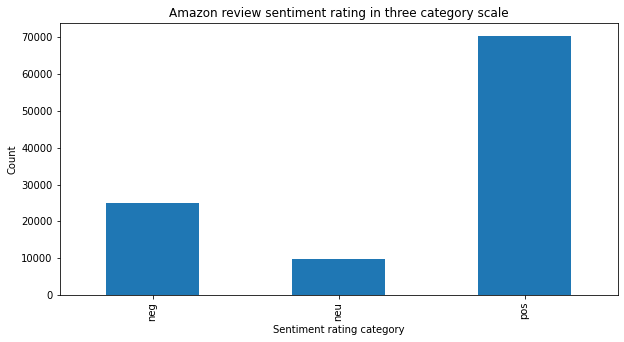

In [7]:
from matplotlib import pyplot as plt
DataFrame["Sentiment"].map({2:'pos', 1:'neu', 0:'neg'}).value_counts().sort_index().plot(kind="bar", title="Sentiment",figsize=(10,5))

plt.title("Amazon review sentiment rating in three category scale")
plt.ylabel("Count")
plt.xlabel("Sentiment rating category")


# Train, Validation and Test Split

In [8]:
# Train and validation split
from sklearn.model_selection import train_test_split
training_me, validation = train_test_split(DataFrame, test_size=.2)

In [9]:
# Train and test split
from sklearn.model_selection import train_test_split
training, test = train_test_split(training_me, test_size=.2)

In [10]:

print(training["short_review"].str.len().max())
print(validation["short_review"].str.len().max())
print(test["short_review"].str.len().max())



16009
12718
15829


In [11]:
# dataframe to list
training_reviews = training['short_review'].values.tolist()
training_labels = training['Sentiment'].tolist()

validation_reviews = validation['short_review'].values.tolist()
validation_labels = validation['Sentiment'].tolist()

test_reviews = test['short_review'].values.tolist()
test_labels = test['Sentiment'].tolist()

In [ ]:
validation_labels

In [13]:
# feeding training and validation review text in TextVectorization for adaptation, taken from Dr. Leslie Kerby's lecture
vocab_size = 1000 
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size) 
text_vec_layer.adapt(training_reviews) 
text_vec_layer.adapt(validation_reviews)


In [14]:
# Converting to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((training_reviews, training_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((validation_reviews, validation_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_reviews, test_labels))

In [15]:
train_set = train_dataset.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = val_dataset.batch(32).prefetch(1)
test_set=test_dataset.batch(32).prefetch(1)

# Modelling with GRU and LSTM

In [16]:
#Model Derived from Dr. Leslie Kerby's lecture
%%time
embed_size = 128 
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer, 
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(3, activation="sigmoid")
])
model.compile(loss="SparseCategoricalCrossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=(valid_set), epochs=10)



Epoch 1/10
2100/2100 [==============================] - 51s 20ms/step - loss: 0.8320 - accuracy: 0.6704 - val_loss: 0.8385 - val_accuracy: 0.6722
Epoch 2/10
2100/2100 [==============================] - 42s 20ms/step - loss: 0.8266 - accuracy: 0.6713 - val_loss: 0.6715 - val_accuracy: 0.7441
Epoch 3/10
2100/2100 [==============================] - 42s 20ms/step - loss: 0.4624 - accuracy: 0.8266 - val_loss: 0.4180 - val_accuracy: 0.8394
Epoch 4/10
2100/2100 [==============================] - 40s 19ms/step - loss: 0.3919 - accuracy: 0.8506 - val_loss: 0.3997 - val_accuracy: 0.8492
Epoch 5/10
2100/2100 [==============================] - 41s 19ms/step - loss: 0.3620 - accuracy: 0.8618 - val_loss: 0.3865 - val_accuracy: 0.8506
Epoch 6/10
2100/2100 [==============================] - 41s 19ms/step - loss: 0.3397 - accuracy: 0.8710 - val_loss: 0.3986 - val_accuracy: 0.8537
Epoch 7/10
2100/2100 [==============================] - 41s 20ms/step - loss: 0.3197 - accuracy: 0.8777 - val_loss: 0.4046 -

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')


In [ ]:
model.save('/content/gdrive/MyDrive/GRU_FinalProject')

In [ ]:
model.evaluate(test_set)

525/525 [==============================] - 5s 10ms/step - loss: 0.4594 - accuracy: 0.8407


[0.4594235420227051, 0.840735912322998]

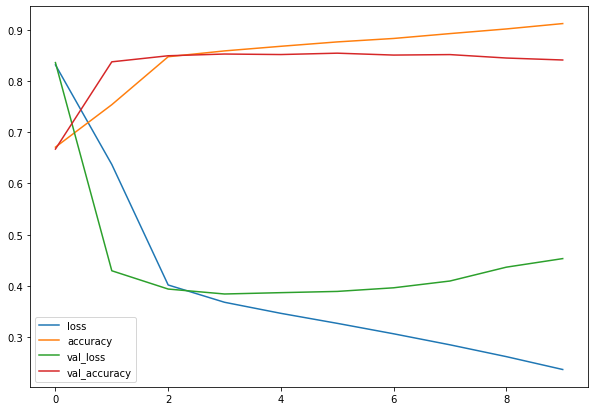

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))

525/525 [==============================] - 4s 8ms/step


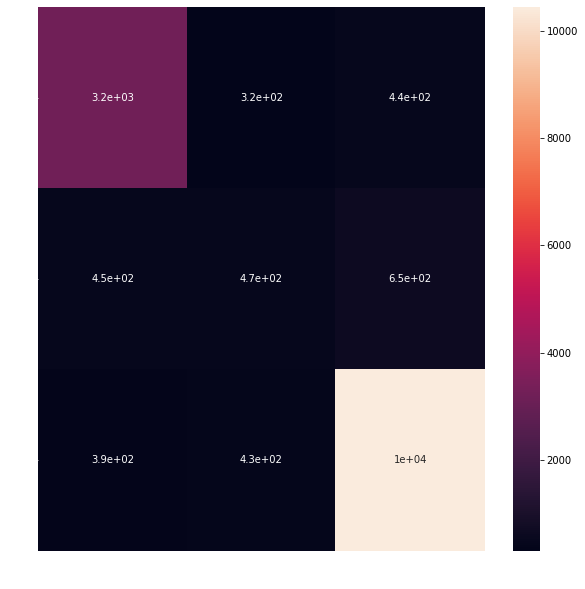

In [ ]:
# Confusion matrix 
import matplotlib.pyplot as plt
import numpy as np
classes = [0,1,2]
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, np.argmax(model.predict(test_reviews), axis=-1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/GRU_FinalProject')

In [ ]:
%%time
embed_size = 128 # embedding dimension
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer, # Had included this in preprocessing before, but note it can be a layer
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(3, activation="sigmoid")
])
model.compile(loss="SparseCategoricalCrossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
2100/2100 [==============================] - 49s 23ms/step - loss: 0.8310 - accuracy: 0.6711 - val_loss: 0.8325 - val_accuracy: 0.6679
Epoch 2/10
2100/2100 [==============================] - 49s 23ms/step - loss: 0.8301 - accuracy: 0.6710 - val_loss: 0.8321 - val_accuracy: 0.6681
Epoch 3/10
2100/2100 [==============================] - 47s 23ms/step - loss: 0.8269 - accuracy: 0.6715 - val_loss: 0.8344 - val_accuracy: 0.6682
Epoch 4/10
2100/2100 [==============================] - 47s 22ms/step - loss: 0.7833 - accuracy: 0.6907 - val_loss: 0.6181 - val_accuracy: 0.7763
Epoch 5/10
2100/2100 [==============================] - 47s 23ms/step - loss: 0.5217 - accuracy: 0.8091 - val_loss: 0.4712 - val_accuracy: 0.8257
Epoch 6/10
2100/2100 [==============================] - 47s 22ms/step - loss: 0.4400 - accuracy: 0.8370 - val_loss: 0.4522 - val_accuracy: 0.8285
Epoch 7/10
2100/2100 [==============================] - 48s 23ms/step - loss: 0.4056 - accuracy: 0.8484 - val_loss: 0.4171 -

In [ ]:
model.save('/content/gdrive/MyDrive/LSTM_finalProject')

In [ ]:
model.evaluate(test_set)

525/525 [==============================] - 6s 11ms/step - loss: 0.2303 - accuracy: 0.9053


[0.23030464351177216, 0.9053345918655396]

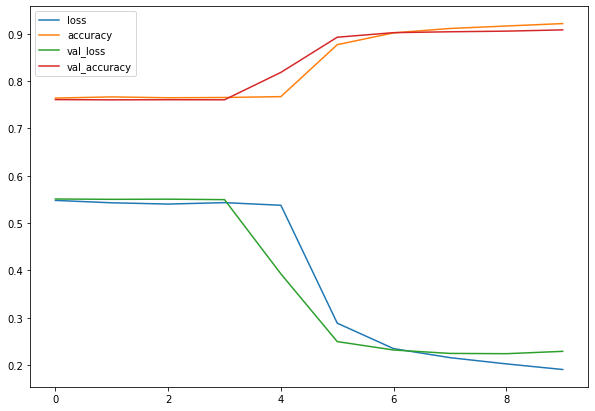

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))

525/525 [==============================] - 5s 9ms/step


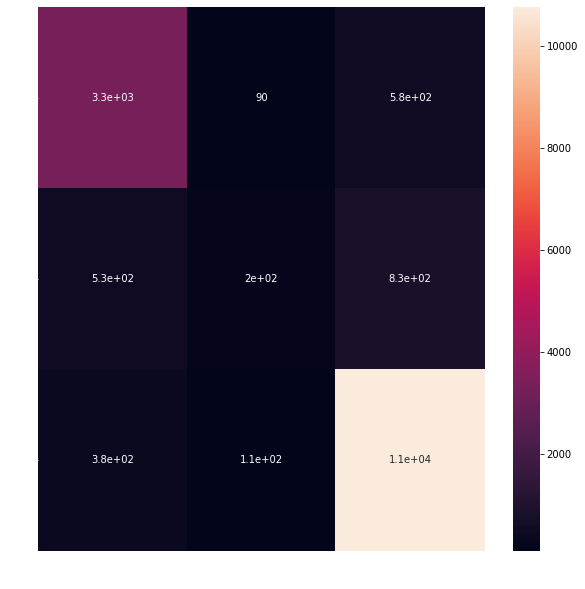

In [ ]:
# Confusion matrix 
import matplotlib.pyplot as plt
import numpy as np
classes = [0,1,2]
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, np.argmax(model.predict(test_reviews), axis=-1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True)
plt.ylabel('True class', color='white')
plt.xlabel('Predicted class', color='white')
plt.tick_params(color='white',labelcolor='white')
plt.show()

# VADER UNSUPERVISED








In [ ]:
training_reviews[14]

'Very nice. Easy to use. got here on time.'

In [ ]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [ ]:
import nltk
nltk.word_tokenize(training_reviews[0])

In [ ]:
nltk.download('vader_lexicon')

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

sentiments= SentimentIntensityAnalyzer()


In [ ]:
sentiments.polarity_scores("Great product good price")

{'neg': 0.0, 'neu': 0.222, 'pos': 0.778, 'compound': 0.7906}

In [ ]:
# dictionary set of all sentiments of reivew
allSentiments={}
i=0
for each in DataFrame["short_review"]:
  allSentiments[i]=sentiments.polarity_scores(each)
  i+=1
  

In [ ]:
DataFrame["short_review"].head()

0                                        Does not work
1    This is a great wiring kit i used it to set up...
2    It works great so much faster than USB charger...
3    This product was purchased to hold a monitor o...
4    it works but it has really bad sound quality. ...
Name: short_review, dtype: object

In [ ]:
allSentiments[0]

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [ ]:
import pandas as pd
allSentiments=pd.DataFrame(allSentiments).T

In [ ]:
allSentiments

,neg,neu,pos,compound
0,0.000,1.000,0.000,0.0000
1,0.022,0.832,0.145,0.8450
2,0.000,0.646,0.354,0.8264
3,0.000,0.777,0.223,0.7650
4,0.257,0.743,0.000,-0.7343
...,...,...,...,...
104970,0.054,0.769,0.177,0.7096
104971,0.083,0.859,0.058,-0.1793
104972,0.000,0.723,0.277,0.8745
104973,0.051,0.917,0.031,-0.2732


In [ ]:
vaders_dataframe=allSentiments.merge(DataFrame_me, left_index=True, right_index=True, how="right")
vaders_dataframe.tail()

,neg,neu,pos,compound,short_review,Sentiment
104970,0.054,0.769,0.177,0.7096,"b""It's a wonderful invention. You don't need t...",4
104971,0.083,0.859,0.058,-0.1793,"b""This is not good item,I can even maket work,...",1
104972,0.000,0.723,0.277,0.8745,b'The cover and skin were both exactly like th...,5
104973,0.051,0.917,0.031,-0.2732,b'I ordered 2 of these cords for both mine and...,1
104974,0.000,0.525,0.475,0.9456,b'Item works better than I had hoped for. Very...,5


Text(0.5, 1.0, 'compound Rating')

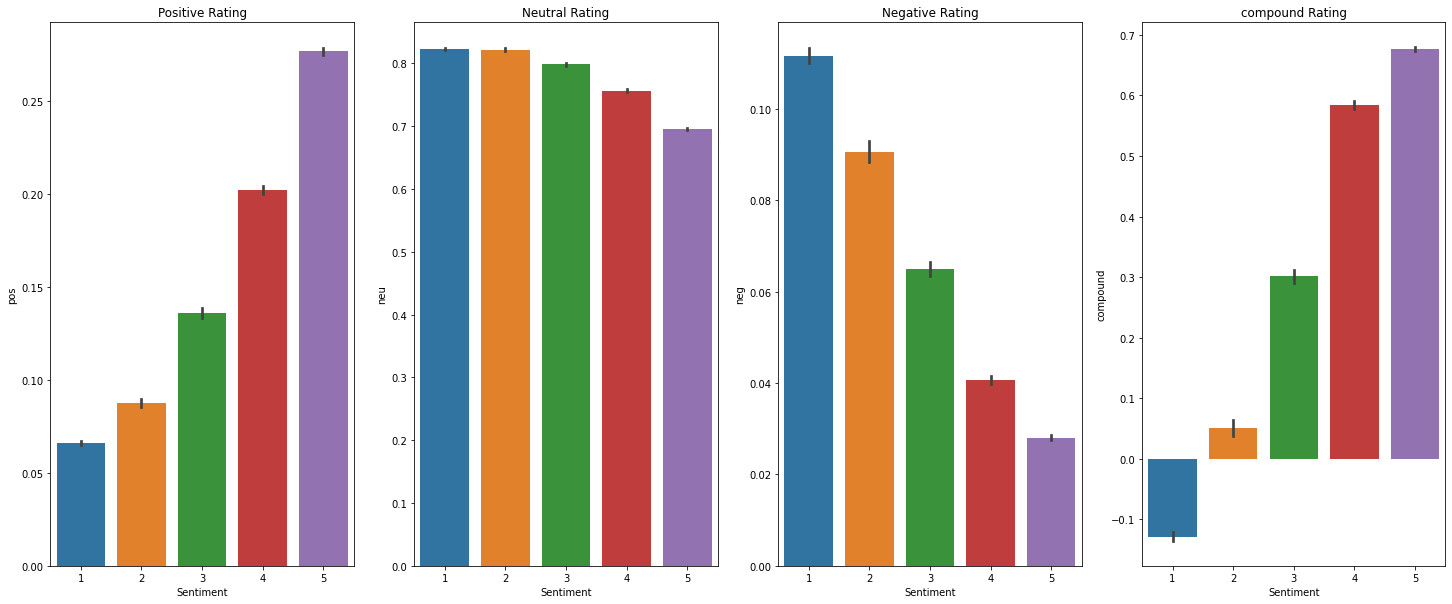

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs= plt.subplots( 1, 4, figsize=(25,10))
sns.barplot(data=vaders_dataframe, x='Sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders_dataframe, x='Sentiment', y='neu', ax=axs[1])
sns.barplot(data=vaders_dataframe, x='Sentiment', y='neg', ax=axs[2])
sns.barplot(data=vaders_dataframe, x='Sentiment', y='compound', ax=axs[3])
axs[0].set_title('Positive Rating')
axs[1].set_title('Neutral Rating')
axs[2].set_title('Negative Rating')
axs[3].set_title('compound Rating')




# HuggingFace Transfer Learning With BERT

In [17]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.0 MB/s 
     |████████████████████████████████| 7.6 MB 71.5 MB/s 
     |████████████████████████████████| 182 kB 99.4 MB/s 


In [21]:
# Converting Prefect tensorflow dataset  into pandas dataframe
DataFrame = tfds.as_dataframe(dataSet)


In [22]:
def reclassify_ratings(input):
  if input<=3:
    return "neg"  
  else:
    return "pos"




In [23]:
#Labelling rating as positive or negative 
DataFrame["Sentiment"] = DataFrame["data/star_rating"].apply(reclassify_ratings).map({'pos':1, 'neg':0})
DataFrame['short_review'] =DataFrame['data/review_body'].str.decode("utf-8")
DataFrame = DataFrame[["short_review", "Sentiment"]]

In [24]:
DataFrame['Sentiment']

0         0
1         1
2         1
3         1
4         0
         ..
104970    1
104971    0
104972    1
104973    0
104974    1
Name: Sentiment, Length: 104975, dtype: int64

In [25]:
DataFrame

,short_review,Sentiment
0,Does not work,0
1,This is a great wiring kit i used it to set up...,1
2,It works great so much faster than USB charger...,1
3,This product was purchased to hold a monitor o...,1
4,it works but it has really bad sound quality. ...,0
...,...,...
104970,It's a wonderful invention. You don't need to ...,1
104971,"This is not good item,I can even maket work,th...",0
104972,The cover and skin were both exactly like the ...,1
104973,I ordered 2 of these cords for both mine and m...,0


Text(0.5, 0, 'Sentiment rating category')

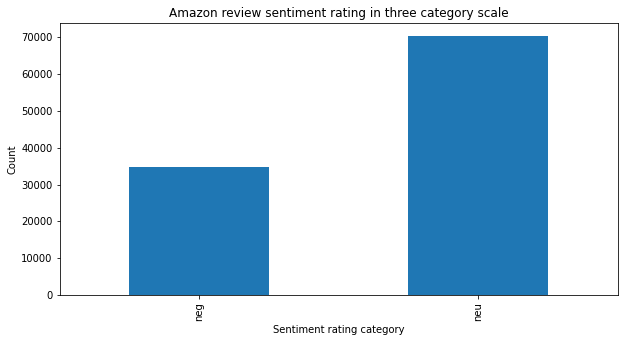

In [26]:
from matplotlib import pyplot as plt
DataFrame["Sentiment"].map({2:'pos', 1:'neu', 0:'neg'}).value_counts().sort_index().plot(kind="bar", title="Sentiment",figsize=(10,5))

plt.title("Amazon review sentiment rating in three category scale")
plt.ylabel("Count")
plt.xlabel("Sentiment rating category")


In [27]:
# Train and validation split
from sklearn.model_selection import train_test_split
training_me, validation = train_test_split(DataFrame, test_size=.2)

In [28]:
# Train and test split
from sklearn.model_selection import train_test_split
training, test = train_test_split(training_me, test_size=.2)

In [29]:

print(training["short_review"].str.len().max())
print(validation["short_review"].str.len().max())
print(test["short_review"].str.len().max())



16009
14901
12718


In [30]:
# dataframe to list
training_reviews = training['short_review'].values.tolist()
training_labels = training['Sentiment'].tolist()

validation_reviews = validation['short_review'].values.tolist()
validation_labels = validation['Sentiment'].tolist()

test_reviews = test['short_review'].values.tolist()
test_labels = test['Sentiment'].tolist()

In [ ]:
validation_labels

In [31]:
from transformers import TFAutoModelForSequenceClassification
from transformers import BertTokenizer

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
type(training_reviews)

list

In [33]:
train_encodings=[]
for each in training_reviews:
  train_encodings.append(tokenizer.encode_plus(each,
                              max_length=126,
                              truncation=True,
                              padding='max_length',
                              return_attention_mask = True,
                              add_special_tokens = True))

val_encodings=[]
for each in validation_reviews:
  val_encodings.append(tokenizer.encode_plus(each,
                              max_length=126,
                              truncation=True,
                              padding='max_length',
                              return_attention_mask = True,
                              add_special_tokens = True))

test_encodings=[]
for each in test_reviews:
  test_encodings.append(tokenizer.encode_plus(each,
                              max_length=126,
                              truncation=True,
                              padding='max_length',
                              return_attention_mask = True,
                              add_special_tokens = True))

In [ ]:
train_encodings[5]

{'input_ids': [101, 2023, 2003, 1037, 2092, 2328, 9233, 2048, 2126, 9099, 3401, 16402, 2007, 2116, 2838, 2179, 2006, 2192, 2218, 22229, 22173, 3807, 2004, 2172, 2004, 2023, 2028, 1012, 2023, 3131, 2003, 3214, 2000, 2022, 1996, 2117, 1999, 1037, 2275, 1997, 2048, 1012, 2017, 2024, 3517, 2000, 2525, 2219, 1996, 13003, 2918, 2734, 2000, 3715, 2023, 2557, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2045, 2024, 2116, 16611, 2800, 2005, 2023, 2557, 1010, 2164, 6556, 23025, 1010, 4540, 26734, 1010, 1998, 2482, 13003, 24551, 1012, 2009, 3310, 2007, 1996, 23025, 13354, 2000, 18833, 19400, 2008, 4473, 2017, 2000, 2565, 1996, 3149, 13139, 1012, 2023, 2003, 1996, 25551, 2126, 2000, 4607, 1999, 1996, 2734, 2592, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [34]:
def mapToDict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
  }, label

In [35]:
inputIDs_train = []
attentionMasks_train= []
token_type_ids_train=[]


for each in train_encodings:
  inputIDs_train.append(each['input_ids'])
  attentionMasks_train.append(each['attention_mask'])
  token_type_ids_train.append(each['token_type_ids'])




tf_training=tf.data.Dataset.from_tensor_slices((inputIDs_train, token_type_ids_train,attentionMasks_train, training_labels)).map(mapToDict)


In [37]:
inputIDs_valid = []
#tokenTypeIDs = []
attentionMasks_valid= []
token_type_ids_valid=[]


for each in val_encodings:
  inputIDs_valid.append(each['input_ids'])
  #tokenTypeIDs.append(each['token_type_ids'])
  attentionMasks_valid.append(each['attention_mask'])
  token_type_ids_valid.append(each['token_type_ids'])



tf_validation=tf.data.Dataset.from_tensor_slices((inputIDs_valid, token_type_ids_valid, attentionMasks_valid, validation_labels)).map(mapToDict)

In [39]:
inputIDs_valid = []
#tokenTypeIDs = []
attentionMasks_valid= []
token_type_ids_valid=[]


for each in test_encodings:
  inputIDs_valid.append(each['input_ids'])
  #tokenTypeIDs.append(each['token_type_ids'])
  attentionMasks_valid.append(each['attention_mask'])
  token_type_ids_valid.append(each['token_type_ids'])



tf_test=tf.data.Dataset.from_tensor_slices((inputIDs_valid, token_type_ids_valid, attentionMasks_valid, test_labels)).map(mapToDict)

In [40]:
train_set = tf_training.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = tf_validation.batch(32).prefetch(1)
test_set=tf_test.batch(32).prefetch(1)

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)


Epoch 1/5
2100/2100 [==============================] - 1845s 867ms/step - loss: 7.6799 - accuracy: 0.6694 - val_loss: 7.6836 - val_accuracy: 0.6708
Epoch 2/5
2100/2100 [==============================] - 1814s 864ms/step - loss: 7.6834 - accuracy: 0.6695 - val_loss: 7.6836 - val_accuracy: 0.6708
Epoch 3/5
2100/2100 [==============================] - 1814s 864ms/step - loss: 7.6834 - accuracy: 0.6695 - val_loss: 7.6836 - val_accuracy: 0.6708
Epoch 4/5
2100/2100 [==============================] - 1814s 864ms/step - loss: 7.6834 - accuracy: 0.6695 - val_loss: 7.6836 - val_accuracy: 0.6708
Epoch 5/5
2100/2100 [==============================] - 1815s 864ms/step - loss: 7.6834 - accuracy: 0.6695 - val_loss: 7.6836 - val_accuracy: 0.6708


In [19]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [ ]:
model.save('/content/gdrive/MyDrive/BERT Model')

In [41]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/BERT Model')

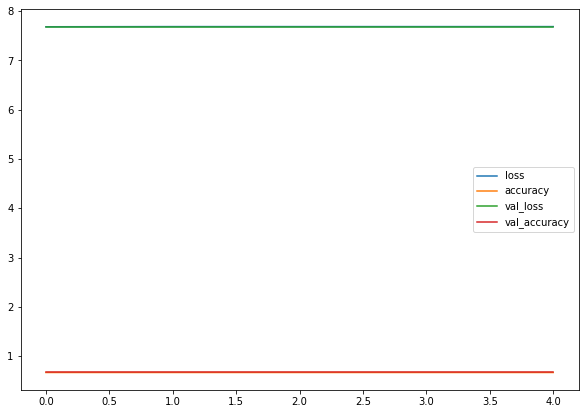

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10,7))